In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
keras = tf.keras

with open("companies.csv" ,encoding='utf-8') as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 2567986 characters


In [3]:
# Get a unique identifier for each char in the corpus, 
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))
print(encoding)
print(decoding)

Our corpus contains 150 unique characters.
{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, '=': 28, '>': 29, '?': 30, '@': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, '\\': 59, ']': 60, '^': 61, '_': 62, 'a': 63, 'b': 64, 'c': 65, 'd': 66, 'e': 67, 'f': 68, 'g': 69, 'h': 70, 'i': 71, 'j': 72, 'k': 73, 'l': 74, 'm': 75, 'n': 76, 'o': 77, 'p': 78, 'q': 79, 'r': 80, 's': 81, 't': 82, 'u': 83, 'v': 84, 'w': 85, 'x': 86, 'y': 87, 'z': 88, '{': 89, '|': 90, '}': 91, '~': 92, '\x81': 93, '\x82': 94, '\x83': 95, '\x84': 96, '\x85': 97, '\x86': 98, '\x87': 99, '\x88': 100, '\x89': 101, '\x8a': 102, '\x8

## Many to one approach

In [4]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 10
skip = 3
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 855992 sentences of length 10


In [5]:
print(X_data[0])
print([decoding[idx] for idx in X_data[0]])
print(decoding[y_data[0]])

[39, 63, 81, 70, 78, 74, 63, 87, 1, 40]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
n


In [6]:
# Vectorize our data and labels. We want everything in one-hot.
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, num_chars), dtype=np.bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.shape, sentence_length))

Sanity check y. Dimension: (855992, 150) # Sentences: 855992 Characters in corpus: 150
Sanity check X. Dimension: (855992, 10, 150) Sentence length: 10


In [7]:
# Define our model
model = keras.models.Sequential()
model.add(keras.layers.GRU(256, input_shape=(sentence_length, num_chars), 
                    return_sequences=False))
model.add(keras.layers.Dense(num_chars))
model.add(keras.layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               313344    
_________________________________________________________________
dense (Dense)                (None, 150)               38550     
_________________________________________________________________
activation (Activation)      (None, 150)               0         
Total params: 351,894
Trainable params: 351,894
Non-trainable params: 0
_________________________________________________________________


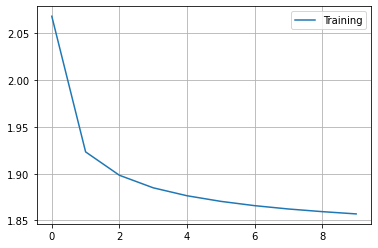

In [18]:
#training time
log = model.fit(X, y, epochs=10, batch_size=128)
plt.plot(log.history['loss'], label='Training')
plt.legend()
plt.grid()

In [17]:

def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern

seed_pattern = make_seed("Artificial")

X = np.zeros((1, sentence_length, num_chars), dtype=np.float)
for i, character in enumerate(seed_pattern):
    X[0, i, encoding[character]] = 1

generated_text = ""

names = 1

while names <= 10:
    output_prob = model.predict(X, verbose=0)[0]
    # in previous line predict() gives a tensor of shape (1, 65) 
    # with 1 being the size of the batch, for that we use [0] to get a vector
    prediction = np.random.choice(num_chars, p = output_prob )
    generated_text += decoding[prediction]
    activations = np.zeros((1, 1, num_chars), dtype=np.bool)
    activations[0, 0, prediction] = 1
    #now remove first char and glue the predicted one
    X = np.concatenate((X[:, 1:, :], activations), axis=1)
    
    if generated_text[-1] == '\n':
        names += 1
    
print(seed_pattern + generated_text)

Artificial Group
Corread
Datwalga
Europeace Plpiened
DAGII
Agnisus Communications
Likomoon Films
Creaford Group
PhysioMed
Nuksto



The words seem to have improved when compared to PW11. There are multiple words which are syntactically correct now. The others could also just be a intended misspelling for the sake of a nice sounding company name. The loss function was also decreased more than in PW11.

## Many to many approach

In [ ]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 10
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i+1:i+1 + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append([encoding[char] for char in next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

In [ ]:
print(X_data[0])

In [ ]:
print([decoding[idx] for idx in X_data[0]])
print([decoding[idx] for idx in y_data[0]])

In [ ]:
# Vectorize our data and labels. We want everything in one-hot.
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
for i, sentence in enumerate(y_data):
    for t, encoded_char in enumerate(sentence):
        y[i, t, encoded_char] = 1

In [ ]:
# Define our model
modelmm = keras.models.Sequential()
modelmm.add(keras.layers.GRU(256, input_shape=(sentence_length, num_chars), 
                    return_sequences=True))
modelmm.add(keras.layers.TimeDistributed(keras.layers.Dense(num_chars,
                                                          activation='softmax')))
modelmm.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
modelmm.summary()

20063/20063 [==============================] - 1836s 91ms/step - loss: 2.0682 - accuracy: 0.4076
Epoch 2/10
20063/20063 [==============================] - 1636s 82ms/step - loss: 1.9233 - accuracy: 0.4427
Epoch 3/10
20063/20063 [==============================] - 1651s 82ms/step - loss: 1.8983 - accuracy: 0.4484
Epoch 4/10
20063/20063 [==============================] - 1694s 84ms/step - loss: 1.8849 - accuracy: 0.4514
Epoch 5/10
20063/20063 [==============================] - 2243s 112ms/step - loss: 1.8764 - accuracy: 0.4532
Epoch 6/10
20063/20063 [==============================] - 2153s 107ms/step - loss: 1.8704 - accuracy: 0.4547- loss: 1.8704 - accuracy
Epoch 7/10
20063/20063 [==============================] - 2033s 101ms/step - loss: 1.8658 - accuracy: 0.4556- loss: 1.8658 - ac
Epoch 8/10
20063/20063 [==============================] - 2045s 102ms/step - loss: 1.8623 - accuracy: 0.4564
Epoch 9/10
20063/20063 [==============================] - 1606s 80ms/step - loss: 1.8594 - accuracy

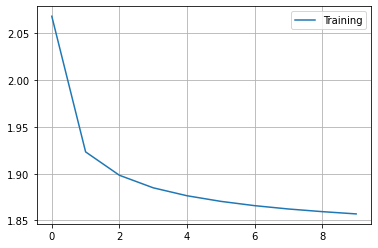

In [15]:
#training time
log = modelmm.fit(X, y, epochs=10, batch_size=128)
plt.plot(log.history['loss'], label='Training')
plt.legend()
plt.grid()

In [20]:
def make_seed(seed_phrase=""):
        if seed_phrase:  # make sure the seed has the right length
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:            # sample randomly the seed from corpus
            seed = random.randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]
        return pattern

seed_pattern = make_seed("Artificial")

X = np.zeros((1, sentence_length, num_chars), dtype=np.float)
for i, character in enumerate(seed_pattern):
    X[0, i, encoding[character]] = 1

generated_text = ""

names = 1

while names <= 10:
    output_prob = modelmm.predict(X, verbose=0)[0][-1]
    # in previous line predict() gives a tensor of shape (1, 20, 65) 
    # with 1 being the size of the batch, for that we use [0][-1] 
    # to remove the batch dim and get the last prediction : a vector of size 65
    prediction = np.random.choice(num_chars, p = output_prob )
    generated_text += decoding[prediction]
    activations = np.zeros((1, 1, num_chars), dtype=np.bool)
    activations[0, 0, prediction] = 1
    #now remove first char and glue the predicted one
    X = np.concatenate((X[:, 1:, :], activations), axis=1)
        
    if generated_text[-1] == '\n':
        names += 1
    
print(f"{seed_pattern}{generated_text}")

Artificial Training
Watsport
Yumcle
80oodvian
Delta League
Canvas Environmental Press
4chino Overseas
5Dr.i.,LLZ.C"
SiteBaby
Rev



The names seem to be even more authentic. The loss was even further improved from PW11!.